# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


Le projet a été préparé par Gabriel Gobeil, associé de recherche à Polytechnique Montréal.

---
# Projet A2022 : Récolte des cerfs de Virginie


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/23b6d8c44f1247c78e19a6a902f804af

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- recolte.csv
- permis.csv
- meteo.csv
- essence.csv
- test.csv

**Déposez ces fichiers dans un dossier nommé *data* dans le répertoire de ce calepin.**

Le fichier *recolte.csv* contient les statistiques de chasse au cerf de Viriginie. On y retrouve le nombre de cerfs mâles adultes récoltés annuellement dans certaines zones de chasse du Québec, listé selon le type d'engin utilisé.

Le fichier *permis.csv* contient des informations sur le nombre de permis de chasse aux cerfs de Virginie alloués aux résidents et non-résidents de 1999 à 2020.

Le fichier *meteo.csv* contient certaines variables météorologiques enregistrées à la station Montréal-Trudeau de 1999 à 2021 :
- Mean Temp (°C)	
- Total Rain (mm)	
- Total Snow (cm)	
- Snow on Grnd (cm)

Le fichier *essence.csv* contient des informations sur le prix de détail moyen par mois de l'essence pour Québec et Montréal de 1999 à 2021. Des renseignements additionnels sur les données sont disponibles à l'adresse suivante : https://www150.statcan.gc.ca/t1/tbl1/fr/cv.action?pid=1810000101

Le fichier *test.csv* contient les zones de chasse pour lesquels vous devez prédire le nombre de cerfs mâles adultes récoltés pour l'année 2021, peu importe l'engin de chasse utilisé. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est suffisante.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

In [259]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, Distributions, Impute, GLM, Lasso

import StatsBase
import Random

In [260]:
ENV["COLUMNS"]=200

200

---
## 1. Chargement de données

#### Récolte annuelle de cerfs par zones de chasse selon les différents engins

In [261]:
recolte = CSV.read("data/recolte.csv", DataFrame)
last(recolte, 30)

30×4 DataFrame
│ Row │ Année │ Zone  │ Engin    │ Cerfs │
│     │ Int64 │ Int64 │ String15 │ Int64 │
├─────┼───────┼───────┼──────────┼───────┤
│ 1   │ 2020  │ 10    │ Fusil    │ 86    │
│ 2   │ 2020  │ 11    │ ACB      │ 1     │
│ 3   │ 2020  │ 11    │ Arbalète │ 174   │
│ 4   │ 2020  │ 11    │ Arc      │ 14    │
│ 5   │ 2020  │ 11    │ Carabine │ 524   │
│ 6   │ 2020  │ 11    │ Fusil    │ 8     │
│ 7   │ 2020  │ 12    │ Arbalète │ 0     │
│ 8   │ 2020  │ 12    │ Arc      │ 1     │
│ 9   │ 2020  │ 12    │ Carabine │ 8     │
│ 10  │ 2020  │ 13    │ Carabine │ 6     │
⋮
│ 20  │ 2020  │ 26    │ Fusil    │ 84    │
│ 21  │ 2020  │ 26    │ Arc      │ 8     │
│ 22  │ 2020  │ 26    │ Carabine │ 3     │
│ 23  │ 2020  │ 27    │ ACB      │ 112   │
│ 24  │ 2020  │ 27    │ Arbalète │ 676   │
│ 25  │ 2020  │ 27    │ Arc      │ 15    │
│ 26  │ 2020  │ 27    │ Fusil    │ 77    │
│ 27  │ 2020  │ 28    │ ACB      │ 27    │
│ 28  │ 2020  │ 28    │ Arbalète │ 90    │
│ 29  │ 2020  │ 28    │ Arc      │ 2     │
│ 30  │ 2020  │ 28    │ Fusil    │ 32    │

#### Nombre de permis de chasse alloués annuellement aux résidents et non-résidents

In [262]:
permis = CSV.read("data/permis.csv", DataFrame)
first(permis, 300)

23×5 DataFrame
│ Row │ Année │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │
│     │ Int64 │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │
├─────┼───────┼───────────┼────────────────────────────┼───────────────┼────────┤
│ 1   │ 1998  │ 135409    │ missing                    │ 1230          │ 136639 │
│ 2   │ 1999  │ 131325    │ missing                    │ 1260          │ 132585 │
│ 3   │ 2000  │ 137346    │ missing                    │ 1463          │ 138809 │
│ 4   │ 2001  │ 144074    │ missing                    │ 1551          │ 145625 │
│ 5   │ 2002  │ 151154    │ missing                    │ 1735          │ 152889 │
│ 6   │ 2003  │ 156229    │ missing                    │ 1638          │ 157867 │
│ 7   │ 2004  │ 162691    │ missing                    │ 1830          │ 164521 │
│ 8   │ 2005  │ 162208    │ missing                    │ 1745          │ 163953 │
│ 9   │ 2006  │ 169071    │ missing                    │ 1661          │ 170732 │
│ 10  │ 2007  │ 171684    │ missing                    │ 1646          │ 173330 │
│ 11  │ 2008  │ 161538    │ 8986                       │ 1420          │ 171944 │
│ 12  │ 2009  │ 152388    │ 8826                       │ 1231          │ 162445 │
│ 13  │ 2010  │ 145491    │ 8635                       │ 1108          │ 155234 │
│ 14  │ 2011  │ 140968    │ 8369                       │ 1114          │ 150451 │
│ 15  │ 2012  │ 143470    │ 8795                       │ 1071          │ 153336 │
│ 16  │ 2013  │ 144980    │ 8916                       │ 1049          │ 154945 │
│ 17  │ 2014  │ 143829    │ 8883                       │ 1028          │ 153740 │
│ 18  │ 2015  │ 140789    │ 9286                       │ 1020          │ 151095 │
│ 19  │ 2016  │ 139384    │ 9351                       │ 943           │ 149678 │
│ 20  │ 2017  │ 137224    │ 9723                       │ 913           │ 147860 │
│ 21  │ 2018  │ 134387    │ 9816                       │ 915           │ 145118 │
│ 22  │ 2019  │ 126315    │ 9397                       │ 871           │ 136583 │
│ 23  │ 2020  │ 135722    │ missing                    │ 691           │ 136413 │

#### Moyenne mensuelle du prix de détail de l'essence en cents pour Québec et Montréal

In [263]:
essence = CSV.read("data/essence.csv", DataFrame)
first(essence, 5)

5×3 DataFrame
│ Row │ Mois       │ Québec  │ Montréal │
│     │ Date       │ Float64 │ Float64  │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ 1997-04-01 │ 60.1    │ 60.3     │
│ 2   │ 1997-05-01 │ 60.7    │ 60.5     │
│ 3   │ 1997-06-01 │ 59.4    │ 61.5     │
│ 4   │ 1997-07-01 │ 57.9    │ 59.7     │
│ 5   │ 1997-08-01 │ 62.8    │ 64.0     │

#### Données météorologiques quotidiennes à Montréal-Trudeau entre 1999 et 2021

In [264]:
meteo = CSV.read("data/meteo.csv", DataFrame)
first(meteo, 5)

5×5 DataFrame
│ Row │ Date/Time  │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │
│     │ Date       │ Float64?       │ Float64?        │ Float64?        │ Int64?            │
├─────┼────────────┼────────────────┼─────────────────┼─────────────────┼───────────────────┤
│ 1   │ 1999-01-01 │ -20.5          │ 0.0             │ 1.0             │ 2                 │
│ 2   │ 1999-01-02 │ -19.2          │ 0.0             │ 0.0             │ 2                 │
│ 3   │ 1999-01-03 │ -8.5           │ 1.2             │ 11.4            │ 7                 │
│ 4   │ 1999-01-04 │ -9.4           │ 0.0             │ 0.0             │ 8                 │
│ 5   │ 1999-01-05 │ -14.3          │ 0.0             │ 0.0             │ 8                 │

---
## 1.1. Traitement des données

### 1.1.1. Récoltes selon l'année et la zone

In [265]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[])  # On initialise un DataFrame vide

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end

sort!(new_df, :Année)

last(new_df, 30)

30×3 DataFrame
│ Row │ Année │ Zone  │ Cerfs │
│     │ Int64 │ Int64 │ Int64 │
├─────┼───────┼───────┼───────┤
│ 1   │ 2019  │ 8     │ 3038  │
│ 2   │ 2019  │ 9     │ 966   │
│ 3   │ 2019  │ 10    │ 3004  │
│ 4   │ 2019  │ 11    │ 656   │
│ 5   │ 2019  │ 20    │ 3300  │
│ 6   │ 2019  │ 15    │ 38    │
│ 7   │ 2019  │ 1     │ 281   │
│ 8   │ 2019  │ 13    │ 5     │
│ 9   │ 2019  │ 12    │ 4     │
│ 10  │ 2019  │ 26    │ 60    │
⋮
│ 20  │ 2020  │ 9     │ 1089  │
│ 21  │ 2020  │ 10    │ 2993  │
│ 22  │ 2020  │ 11    │ 721   │
│ 23  │ 2020  │ 20    │ 2302  │
│ 24  │ 2020  │ 15    │ 541   │
│ 25  │ 2020  │ 1     │ 318   │
│ 26  │ 2020  │ 13    │ 6     │
│ 27  │ 2020  │ 12    │ 9     │
│ 28  │ 2020  │ 26    │ 330   │
│ 29  │ 2020  │ 27    │ 880   │
│ 30  │ 2020  │ 28    │ 151   │

In [266]:
recolte = new_df

366×3 DataFrame
│ Row │ Année │ Zone  │ Cerfs │
│     │ Int64 │ Int64 │ Int64 │
├─────┼───────┼───────┼───────┤
│ 1   │ 1999  │ 2     │ 922   │
│ 2   │ 1999  │ 3     │ 1519  │
│ 3   │ 1999  │ 4     │ 4890  │
│ 4   │ 1999  │ 5     │ 2014  │
│ 5   │ 1999  │ 6     │ 4846  │
│ 6   │ 1999  │ 7     │ 1062  │
│ 7   │ 1999  │ 8     │ 2033  │
│ 8   │ 1999  │ 9     │ 1123  │
│ 9   │ 1999  │ 10    │ 5224  │
│ 10  │ 1999  │ 11    │ 965   │
⋮
│ 356 │ 2020  │ 9     │ 1089  │
│ 357 │ 2020  │ 10    │ 2993  │
│ 358 │ 2020  │ 11    │ 721   │
│ 359 │ 2020  │ 20    │ 2302  │
│ 360 │ 2020  │ 15    │ 541   │
│ 361 │ 2020  │ 1     │ 318   │
│ 362 │ 2020  │ 13    │ 6     │
│ 363 │ 2020  │ 12    │ 9     │
│ 364 │ 2020  │ 26    │ 330   │
│ 365 │ 2020  │ 27    │ 880   │
│ 366 │ 2020  │ 28    │ 151   │

### 1.1.2. Permis

In [267]:
last(permis,5)

5×5 DataFrame
│ Row │ Année │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │
│     │ Int64 │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │
├─────┼───────┼───────────┼────────────────────────────┼───────────────┼────────┤
│ 1   │ 2016  │ 139384    │ 9351                       │ 943           │ 149678 │
│ 2   │ 2017  │ 137224    │ 9723                       │ 913           │ 147860 │
│ 3   │ 2018  │ 134387    │ 9816                       │ 915           │ 145118 │
│ 4   │ 2019  │ 126315    │ 9397                       │ 871           │ 136583 │
│ 5   │ 2020  │ 135722    │ missing                    │ 691           │ 136413 │

In [268]:
permis_2021_row = DataFrame("Année" => 2021, "Résidents" => 133947, "Résidents premier abbatage" => missing, "Non-résidents" => 818, "Total" => 134765)
append!(permis, permis_2021_row)


24×5 DataFrame
│ Row │ Année │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │
│     │ Int64 │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │
├─────┼───────┼───────────┼────────────────────────────┼───────────────┼────────┤
│ 1   │ 1998  │ 135409    │ missing                    │ 1230          │ 136639 │
│ 2   │ 1999  │ 131325    │ missing                    │ 1260          │ 132585 │
│ 3   │ 2000  │ 137346    │ missing                    │ 1463          │ 138809 │
│ 4   │ 2001  │ 144074    │ missing                    │ 1551          │ 145625 │
│ 5   │ 2002  │ 151154    │ missing                    │ 1735          │ 152889 │
│ 6   │ 2003  │ 156229    │ missing                    │ 1638          │ 157867 │
│ 7   │ 2004  │ 162691    │ missing                    │ 1830          │ 164521 │
│ 8   │ 2005  │ 162208    │ missing                    │ 1745          │ 163953 │
│ 9   │ 2006  │ 169071    │ missing                    │ 1661          │ 170732 │
│ 10  │ 2007  │ 171684    │ missing                    │ 1646          │ 173330 │
⋮
│ 14  │ 2011  │ 140968    │ 8369                       │ 1114          │ 150451 │
│ 15  │ 2012  │ 143470    │ 8795                       │ 1071          │ 153336 │
│ 16  │ 2013  │ 144980    │ 8916                       │ 1049          │ 154945 │
│ 17  │ 2014  │ 143829    │ 8883                       │ 1028          │ 153740 │
│ 18  │ 2015  │ 140789    │ 9286                       │ 1020          │ 151095 │
│ 19  │ 2016  │ 139384    │ 9351                       │ 943           │ 149678 │
│ 20  │ 2017  │ 137224    │ 9723                       │ 913           │ 147860 │
│ 21  │ 2018  │ 134387    │ 9816                       │ 915           │ 145118 │
│ 22  │ 2019  │ 126315    │ 9397                       │ 871           │ 136583 │
│ 23  │ 2020  │ 135722    │ missing                    │ 691           │ 136413 │
│ 24  │ 2021  │ 133947    │ missing                    │ 818           │ 134765 │

In [269]:
100 * sum(ismissing.(permis[:, :"Résidents premier abbatage"])) / size(permis, 1)

50.0

In [270]:
# puisque presque la moitie des valeur sont manquante pour la colonne Residents premier abbatage nous allons elimine ce feature
# permis = select(permis, Not(:Résidents premier abbatage))
# Ou nous pouvons essaye de remplace par la moyenne
permis_no_missing = permis[.!ismissing.(permis[:, :"Résidents premier abbatage"]), :]
permis_mean = Int64(round(mean(permis_no_missing[:, :"Résidents premier abbatage"])))
replace!(permis."Résidents premier abbatage", missing => permis_mean);
permis

24×5 DataFrame
│ Row │ Année │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │
│     │ Int64 │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │
├─────┼───────┼───────────┼────────────────────────────┼───────────────┼────────┤
│ 1   │ 1998  │ 135409    │ 9082                       │ 1230          │ 136639 │
│ 2   │ 1999  │ 131325    │ 9082                       │ 1260          │ 132585 │
│ 3   │ 2000  │ 137346    │ 9082                       │ 1463          │ 138809 │
│ 4   │ 2001  │ 144074    │ 9082                       │ 1551          │ 145625 │
│ 5   │ 2002  │ 151154    │ 9082                       │ 1735          │ 152889 │
│ 6   │ 2003  │ 156229    │ 9082                       │ 1638          │ 157867 │
│ 7   │ 2004  │ 162691    │ 9082                       │ 1830          │ 164521 │
│ 8   │ 2005  │ 162208    │ 9082                       │ 1745          │ 163953 │
│ 9   │ 2006  │ 169071    │ 9082                       │ 1661          │ 170732 │
│ 10  │ 2007  │ 171684    │ 9082                       │ 1646          │ 173330 │
⋮
│ 14  │ 2011  │ 140968    │ 8369                       │ 1114          │ 150451 │
│ 15  │ 2012  │ 143470    │ 8795                       │ 1071          │ 153336 │
│ 16  │ 2013  │ 144980    │ 8916                       │ 1049          │ 154945 │
│ 17  │ 2014  │ 143829    │ 8883                       │ 1028          │ 153740 │
│ 18  │ 2015  │ 140789    │ 9286                       │ 1020          │ 151095 │
│ 19  │ 2016  │ 139384    │ 9351                       │ 943           │ 149678 │
│ 20  │ 2017  │ 137224    │ 9723                       │ 913           │ 147860 │
│ 21  │ 2018  │ 134387    │ 9816                       │ 915           │ 145118 │
│ 22  │ 2019  │ 126315    │ 9397                       │ 871           │ 136583 │
│ 23  │ 2020  │ 135722    │ 9082                       │ 691           │ 136413 │
│ 24  │ 2021  │ 133947    │ 9082                       │ 818           │ 134765 │

In [271]:
set_default_plot_size(16cm, 10cm)
plot(permis, x=:Année, y=:Total, Geom.line, Geom.point,
    Guide.ylabel("permis vendus"))

In [272]:
plot(permis, x=:Année, y=:Résidents, Geom.line, Geom.point,
    Guide.ylabel("permis residents"))

In [273]:
plot(permis, x=:Année, y=:"Résidents premier abbatage", Geom.line, Geom.point,
    Guide.ylabel("Résidents premier abbatage"))

### 1.1.3. Meteo

In [274]:
first(meteo, 5)

5×5 DataFrame
│ Row │ Date/Time  │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │
│     │ Date       │ Float64?       │ Float64?        │ Float64?        │ Int64?            │
├─────┼────────────┼────────────────┼─────────────────┼─────────────────┼───────────────────┤
│ 1   │ 1999-01-01 │ -20.5          │ 0.0             │ 1.0             │ 2                 │
│ 2   │ 1999-01-02 │ -19.2          │ 0.0             │ 0.0             │ 2                 │
│ 3   │ 1999-01-03 │ -8.5           │ 1.2             │ 11.4            │ 7                 │
│ 4   │ 1999-01-04 │ -9.4           │ 0.0             │ 0.0             │ 8                 │
│ 5   │ 1999-01-05 │ -14.3          │ 0.0             │ 0.0             │ 8                 │

In [275]:
100 * sum(ismissing.(meteo[:, :"Mean Temp (°C)"])) / size(meteo, 1)

0.22399203583872573

In [276]:
100 * sum(ismissing.(meteo[:, :"Total Rain (mm)"])) / size(meteo, 1)

0.32354405176704826

In [277]:
100 * sum(ismissing.(meteo[:, :"Total Snow (cm)"])) / size(meteo, 1)

0.16177202588352413

In [278]:
100 * sum(ismissing.(meteo[:, :"Snow on Grnd (cm)"])) / size(meteo, 1)

24.96266799402688

In [279]:
function replace_missing_with_mean(df, column_name)
    df_no_missing = df[.!ismissing.(df[:, column_name]), :]
    df_mean = mean(df_no_missing[:, column_name])
    df_mean = round(df_mean, digits=1)
    df[column_name] = Missings.coalesce.(df[column_name], df_mean)
    println(df_mean)
    return df
end

meteo = replace_missing_with_mean(meteo, :"Mean Temp (°C)")
100 * sum(ismissing.(meteo[:, :"Mean Temp (°C)"])) / size(meteo, 1)

7.5


0.0

In [280]:
meteo = replace_missing_with_mean(meteo, :"Total Rain (mm)")
100 * sum(ismissing.(meteo[:, :"Total Rain (mm)"])) / size(meteo, 1)

2.3


0.0

In [281]:
meteo = replace_missing_with_mean(meteo, :"Total Snow (cm)")
100 * sum(ismissing.(meteo[:, :"Total Snow (cm)"])) / size(meteo, 1)

0.6


0.0

In [282]:
meteo = replace_missing_with_mean(meteo, :"Snow on Grnd (cm)")
100 * sum(ismissing.(meteo[:, :"Snow on Grnd (cm)"])) / size(meteo, 1)


4.1


0.0

In [283]:
first(meteo, 20)

20×5 DataFrame
│ Row │ Date/Time  │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │
│     │ Date       │ Float64        │ Float64         │ Float64         │ Real              │
├─────┼────────────┼────────────────┼─────────────────┼─────────────────┼───────────────────┤
│ 1   │ 1999-01-01 │ -20.5          │ 0.0             │ 1.0             │ 2                 │
│ 2   │ 1999-01-02 │ -19.2          │ 0.0             │ 0.0             │ 2                 │
│ 3   │ 1999-01-03 │ -8.5           │ 1.2             │ 11.4            │ 7                 │
│ 4   │ 1999-01-04 │ -9.4           │ 0.0             │ 0.0             │ 8                 │
│ 5   │ 1999-01-05 │ -14.3          │ 0.0             │ 0.0             │ 8                 │
│ 6   │ 1999-01-06 │ -7.1           │ 0.0             │ 3.1             │ 8                 │
│ 7   │ 1999-01-07 │ -11.2          │ 0.0             │ 0.8             │ 10                │
│ 8   │ 1999-01-08 │ -12.8          │ 0.0             │ 5.2             │ 8                 │
│ 9   │ 1999-01-09 │ -9.9           │ 0.0             │ 13.8            │ 17                │
│ 10  │ 1999-01-10 │ -14.7          │ 0.0             │ 0.6             │ 21                │
│ 11  │ 1999-01-11 │ -15.6          │ 0.0             │ 0.6             │ 20                │
│ 12  │ 1999-01-12 │ -16.9          │ 0.0             │ 4.6             │ 23                │
│ 13  │ 1999-01-13 │ -19.8          │ 0.0             │ 5.6             │ 23                │
│ 14  │ 1999-01-14 │ -21.7          │ 0.0             │ 3.6             │ 23                │
│ 15  │ 1999-01-15 │ -12.1          │ 0.0             │ 35.8            │ 36                │
│ 16  │ 1999-01-16 │ -5.3           │ 0.2             │ 0.6             │ 40                │
│ 17  │ 1999-01-17 │ 1.3            │ 0.0             │ 0.0             │ 32                │
│ 18  │ 1999-01-18 │ 2.1            │ 15.8            │ 1.2             │ 30                │
│ 19  │ 1999-01-19 │ 1.3            │ 0.0             │ 0.4             │ 24                │
│ 20  │ 1999-01-20 │ -1.7           │ 0.0             │ 1.2             │ 20                │

In [284]:
meteo."Year" = year.(meteo."Date/Time")
meteo_grouped = combine(groupby(meteo, :Year), :"Mean Temp (°C)" => mean => :"Mean Temp (°C)",
    :"Total Rain (mm)" => mean => :"Total Rain (mm)", :"Total Snow (cm)" => mean => :"Total Snow (cm)",
    :"Snow on Grnd (cm)" => mean => :"Snow on Grnd (cm)")
rename!(meteo_grouped, "Year" => "Année")

22×5 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┤
│ 1   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │
│ 2   │ 2000  │ 6.38087        │ 1.85191         │ 0.811202        │ 2.46995           │
│ 3   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │
│ 4   │ 2002  │ 7.55123        │ 1.63233         │ 0.563562        │ 1.68767           │
│ 5   │ 2003  │ 6.43589        │ 2.54767         │ 0.497808        │ 2.56164           │
│ 6   │ 2004  │ 6.24918        │ 2.0847          │ 0.365574        │ 2.45902           │
│ 7   │ 2005  │ 7.46301        │ 2.83452         │ 0.51726         │ 2.71507           │
│ 8   │ 2006  │ 8.20247        │ 3.35671         │ 0.335068        │ 2.31233           │
│ 9   │ 2007  │ 6.89753        │ 1.8211          │ 0.892877        │ 3.65753           │
│ 10  │ 2008  │ 7.02596        │ 2.01858         │ 0.934973        │ 6.29508           │
│ 11  │ 2009  │ 6.67945        │ 2.19616         │ 0.474247        │ 4.02384           │
│ 12  │ 2010  │ 8.46959        │ 2.73918         │ 0.555068        │ 1.84384           │
│ 13  │ 2011  │ 8.02712        │ 3.01205         │ 0.510137        │ 3.1674            │
│ 14  │ 2012  │ 8.53361        │ 1.98306         │ 0.527322        │ 2.01913           │
│ 15  │ 2014  │ 6.86712        │ 2.33808         │ 0.504658        │ 5.65315           │
│ 16  │ 2015  │ 7.13945        │ 2.45836         │ 0.524932        │ 5.73041           │
│ 17  │ 2016  │ 8.13689        │ 2.32322         │ 0.527322        │ 4.38634           │
│ 18  │ 2017  │ 7.60548        │ 2.83507         │ 0.650411        │ 5.00164           │
│ 19  │ 2018  │ 7.35671        │ 2.23205         │ 0.669589        │ 5.34438           │
│ 20  │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │
│ 21  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │
│ 22  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │

### 1.1.4. Essence

In [285]:
essence."Year" = year.(essence."Mois")
essence_grouped = combine(groupby(essence, :Year), :"Québec" => mean => :"Québec",
    :"Montréal" => mean => :"Montréal")
rename!(essence_grouped, "Year" => "Année")

26×3 DataFrame
│ Row │ Année │ Québec  │ Montréal │
│     │ Int64 │ Float64 │ Float64  │
├─────┼───────┼─────────┼──────────┤
│ 1   │ 1997  │ 60.5778 │ 61.6222  │
│ 2   │ 1998  │ 55.1667 │ 56.2667  │
│ 3   │ 1999  │ 61.4583 │ 63.0417  │
│ 4   │ 2000  │ 71.9417 │ 77.1583  │
│ 5   │ 2001  │ 73.95   │ 73.75    │
│ 6   │ 2002  │ 72.1333 │ 71.3583  │
│ 7   │ 2003  │ 77.8    │ 76.6833  │
│ 8   │ 2004  │ 87.0417 │ 85.75    │
│ 9   │ 2005  │ 97.4833 │ 96.35    │
│ 10  │ 2006  │ 102.367 │ 100.767  │
⋮
│ 16  │ 2012  │ 134.508 │ 136.517  │
│ 17  │ 2013  │ 135.208 │ 136.892  │
│ 18  │ 2014  │ 133.042 │ 136.925  │
│ 19  │ 2015  │ 110.083 │ 116.45   │
│ 20  │ 2016  │ 101.517 │ 108.308  │
│ 21  │ 2017  │ 111.933 │ 118.917  │
│ 22  │ 2018  │ 125.542 │ 131.875  │
│ 23  │ 2019  │ 119.4   │ 125.608  │
│ 24  │ 2020  │ 103.567 │ 106.25   │
│ 25  │ 2021  │ 136.558 │ 136.825  │
│ 26  │ 2022  │ 186.7   │ 186.15   │

### 1.1.5. Combine all tables

In [294]:
df = innerjoin(meteo_grouped, permis, on="Année")
df = innerjoin(df, essence_grouped, on="Année")

22×11 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┤
│ 1   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │
│ 2   │ 2000  │ 6.38087        │ 1.85191         │ 0.811202        │ 2.46995           │ 137346    │ 9082                       │ 1463          │ 138809 │ 71.9417 │ 77.1583  │
│ 3   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 9082                       │ 1551          │ 145625 │ 73.95   │ 73.75    │
│ 4   │ 2002  │ 7.55123        │ 1.63233         │ 0.563562        │ 1.68767           │ 151154    │ 9082                       │ 1735          │ 152889 │ 72.1333 │ 71.3583  │
│ 5   │ 2003  │ 6.43589        │ 2.54767         │ 0.497808        │ 2.56164           │ 156229    │ 9082                       │ 1638          │ 157867 │ 77.8    │ 76.6833  │
│ 6   │ 2004  │ 6.24918        │ 2.0847          │ 0.365574        │ 2.45902           │ 162691    │ 9082                       │ 1830          │ 164521 │ 87.0417 │ 85.75    │
│ 7   │ 2005  │ 7.46301        │ 2.83452         │ 0.51726         │ 2.71507           │ 162208    │ 9082                       │ 1745          │ 163953 │ 97.4833 │ 96.35    │
│ 8   │ 2006  │ 8.20247        │ 3.35671         │ 0.335068        │ 2.31233           │ 169071    │ 9082                       │ 1661          │ 170732 │ 102.367 │ 100.767  │
│ 9   │ 2007  │ 6.89753        │ 1.8211          │ 0.892877        │ 3.65753           │ 171684    │ 9082                       │ 1646          │ 173330 │ 106.442 │ 104.333  │
│ 10  │ 2008  │ 7.02596        │ 2.01858         │ 0.934973        │ 6.29508           │ 161538    │ 8986                       │ 1420          │ 171944 │ 120.1   │ 118.792  │
│ 11  │ 2009  │ 6.67945        │ 2.19616         │ 0.474247        │ 4.02384           │ 152388    │ 8826                       │ 1231          │ 162445 │ 97.6667 │ 97.7417  │
│ 12  │ 2010  │ 8.46959        │ 2.73918         │ 0.555068        │ 1.84384           │ 145491    │ 8635                       │ 1108          │ 155234 │ 106.458 │ 107.842  │
│ 13  │ 2011  │ 8.02712        │ 3.01205         │ 0.510137        │ 3.1674            │ 140968    │ 8369                       │ 1114          │ 150451 │ 128.025 │ 130.492  │
│ 14  │ 2012  │ 8.53361        │ 1.98306         │ 0.527322        │ 2.01913           │ 143470    │ 8795                       │ 1071          │ 153336 │ 134.508 │ 136.517  │
│ 15  │ 2014  │ 6.86712        │ 2.33808         │ 0.504658        │ 5.65315           │ 143829    │ 8883                       │ 1028          │ 153740 │ 133.042 │ 136.925  │
│ 16  │ 2015  │ 7.13945        │ 2.45836         │ 0.524932        │ 5.73041           │ 140789    │ 9286                       │ 1020          │ 151095 │ 110.083 │ 116.45   │
│ 17  │ 2016  │ 8.13689        │ 2.32322         │ 0.527322        │ 4.38634           │ 139384    │ 9351                       │ 943           │ 149678 │ 101.517 │ 108.308  │
│ 18  │ 2017  │ 7.60548        │ 2.83507         │ 0.650411        │ 5.00164           │ 137224    │ 9723                       │ 913           │ 147860 │ 111.933 │ 118.917  │
│ 19  │ 2018  │ 7.35671        │ 2.23205         │ 0.669589        │ 5.34438           │ 134387    │ 9816                       │ 915           │ 145118 │ 125.542 │ 131.875  │
│ 20  │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 9397       

In [295]:
df_test = df[df."Année" .== 2021, :]

1×11 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┤
│ 1   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │

In [296]:
df = innerjoin(df, recolte, on="Année")

349×13 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │ Zone  │ Cerfs │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │ Int64 │ Int64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┼───────┼───────┤
│ 1   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 2     │ 922   │
│ 2   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 3     │ 1519  │
│ 3   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 4     │ 4890  │
│ 4   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 5     │ 2014  │
│ 5   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 6     │ 4846  │
│ 6   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 7     │ 1062  │
│ 7   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 8     │ 2033  │
│ 8   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 9     │ 1123  │
│ 9   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 10    │ 5224  │
│ 10  │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 11    │ 965   │
⋮
│ 339 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 9     │ 1089  │
│ 340 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 10    │ 2993  │
│ 341 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 11    │ 721   │
│ 342 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 20    │ 2302  │
│ 343 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 15    │ 541   │
│ 344 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 1     │ 318   │
│ 345 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 13    │ 6     │
│ 346 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691        

In [297]:
last(df, 5)

5×13 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │ Zone  │ Cerfs │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │ Int64 │ Int64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┼───────┼───────┤
│ 1   │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 13    │ 6     │
│ 2   │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 12    │ 9     │
│ 3   │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 26    │ 330   │
│ 4   │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 27    │ 880   │
│ 5   │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 28    │ 151   │

In [298]:
for i in 1:size(df, 2)
    println("Number of missing values in column ", names(df)[i], ": ", sum(ismissing.(df[:, i])))
end


Number of missing values in column Année: 0
Number of missing values in column Mean Temp (°C): 0
Number of missing values in column Total Rain (mm): 0
Number of missing values in column Total Snow (cm): 0
Number of missing values in column Snow on Grnd (cm): 0
Number of missing values in column Résidents: 0
Number of missing values in column Résidents premier abbatage: 0
Number of missing values in column Non-résidents: 0
Number of missing values in column Total: 0
Number of missing values in column Québec: 0
Number of missing values in column Montréal: 0
Number of missing values in column Zone: 0
Number of missing values in column Cerfs: 0


### 1.1.6. Separation des donnees en train et validation

In [299]:
# get all the years in df
Random.seed!(1)

ntrain = round(Int, 1*nrow(df))

train_id = sample(1:nrow(df), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(df), train_id)

transtrain = df[train_id, :]
transvalid = df[valid_id, :]

# ensure that both dataframes have all the zones of the original dataset (new_zones_df)

zones = unique(df."Zone")
train_zones = unique(transtrain."Zone")
valid_zones = unique(transvalid."Zone")

# we can use setdiff to get the zones that are not in the train_zones and valid_zones
train_missing_zones = setdiff(zones, train_zones)
valid_missing_zones = setdiff(zones, valid_zones)

# we can use the following to add the missing zones to the train and validation sets
transtrain = vcat(transtrain, df[df."Zone" .∈ Ref(train_missing_zones), :])
transvalid = vcat(transvalid, df[df."Zone" .∈ Ref(valid_missing_zones), :])
df_train = transtrain
df_valid = transvalid
# transtrain = new_zones_df[new_zones_df."Année" .∈ Ref(train_years), :]
# transvalid = new_zones_df[new_zones_df."Année" .∈ Ref(valid_years), :]
# now lets get the rows of the train and validation sets
# df_train = df[df."Année" .∈ train_years, :]
# df_valid = df[df."Année" .∈ valid_years, :]

349×13 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │ Zone  │ Cerfs │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │ Int64 │ Int64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┼───────┼───────┤
│ 1   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 2     │ 922   │
│ 2   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 3     │ 1519  │
│ 3   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 4     │ 4890  │
│ 4   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 5     │ 2014  │
│ 5   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 6     │ 4846  │
│ 6   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 7     │ 1062  │
│ 7   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 8     │ 2033  │
│ 8   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 9     │ 1123  │
│ 9   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 10    │ 5224  │
│ 10  │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 11    │ 965   │
⋮
│ 339 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 9     │ 1089  │
│ 340 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 10    │ 2993  │
│ 341 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 11    │ 721   │
│ 342 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 20    │ 2302  │
│ 343 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 15    │ 541   │
│ 344 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 1     │ 318   │
│ 345 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 13    │ 6     │
│ 346 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691        

In [254]:
# get all the years in df
years = unique(df."Année")
# separate 80% of the years for the train set and 20% for the validation set
Random.seed!(2313)

ntrain = round(Int, .8*length(years))

train_years = sample(years, ntrain, replace=false, ordered=true)
valid_years = setdiff(years, train_years)

# now lets get the rows of the train and validation sets
# df_train = df[df."Année" .∈ train_years, :]
# df_valid = df[df."Année" .∈ valid_years, :]

4-element Vector{Int64}:
 2001
 2014
 2018
 2020

In [255]:
df_train = df[df."Année" .∈ Ref(train_years), :]

282×9 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Non-résidents │ Zone  │ Cerfs │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Int64         │ Int64 │ Int64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼───────────────┼───────┼───────┤
│ 1   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 2     │ 922   │
│ 2   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 3     │ 1519  │
│ 3   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 4     │ 4890  │
│ 4   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 5     │ 2014  │
│ 5   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 6     │ 4846  │
│ 6   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 7     │ 1062  │
│ 7   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 8     │ 2033  │
│ 8   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 9     │ 1123  │
│ 9   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 10    │ 5224  │
│ 10  │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 1260          │ 11    │ 965   │
⋮
│ 272 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 9     │ 966   │
│ 273 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 10    │ 3004  │
│ 274 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 11    │ 656   │
│ 275 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 20    │ 3300  │
│ 276 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 15    │ 38    │
│ 277 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 1     │ 281   │
│ 278 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 13    │ 5     │
│ 279 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 12    │ 4     │
│ 280 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 26    │ 60    │
│ 281 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 27    │ 586   │
│ 282 │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 871           │ 28    │ 69    │

In [256]:
df_valid = df[df."Année" .∈ Ref(valid_years), :]

67×9 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Non-résidents │ Zone  │ Cerfs │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Int64         │ Int64 │ Int64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼───────────────┼───────┼───────┤
│ 1   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 2     │ 801   │
│ 2   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 3     │ 1374  │
│ 3   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 4     │ 4199  │
│ 4   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 5     │ 1847  │
│ 5   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 6     │ 4837  │
│ 6   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 7     │ 1260  │
│ 7   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 8     │ 2636  │
│ 8   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 9     │ 1635  │
│ 9   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 10    │ 7056  │
│ 10  │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 1551          │ 11    │ 1397  │
⋮
│ 57  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 9     │ 1089  │
│ 58  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 10    │ 2993  │
│ 59  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 11    │ 721   │
│ 60  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 20    │ 2302  │
│ 61  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 15    │ 541   │
│ 62  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 1     │ 318   │
│ 63  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 13    │ 6     │
│ 64  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 12    │ 9     │
│ 65  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 26    │ 330   │
│ 66  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 27    │ 880   │
│ 67  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 691           │ 28    │ 151   │

In [257]:
train_years

17-element Vector{Int64}:
 1999
 2000
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2009
 2010
 2011
 2012
 2015
 2016
 2017
 2019

In [258]:
valid_years

4-element Vector{Int64}:
 2001
 2014
 2018
 2020

In [233]:
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(df_train), dims=1)
function standardize_data(df, dt)
    transdata = StatsBase.transform(dt, Matrix{Float64}(df))
    transdata = DataFrame(transdata, names(df))
    transdata."Zone" = df."Zone"
    transdata."Cerfs" = df."Cerfs"
    return transdata
end
    
# transtrain = standardize_data(df_train, dt)
# transvalid = standardize_data(df_valid, dt)
transtrain = df_train
transvalid = df_valid

349×13 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │ Zone  │ Cerfs │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │ Int64 │ Int64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┼───────┼───────┤
│ 1   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 2     │ 922   │
│ 2   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 3     │ 1519  │
│ 3   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 4     │ 4890  │
│ 4   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 5     │ 2014  │
│ 5   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 6     │ 4846  │
│ 6   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 7     │ 1062  │
│ 7   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 8     │ 2033  │
│ 8   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 9     │ 1123  │
│ 9   │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 10    │ 5224  │
│ 10  │ 1999  │ 8.23781        │ 2.10712         │ 0.472055        │ 2.08219           │ 131325    │ 9082                       │ 1260          │ 132585 │ 61.4583 │ 63.0417  │ 11    │ 965   │
⋮
│ 339 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 9     │ 1089  │
│ 340 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 10    │ 2993  │
│ 341 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 11    │ 721   │
│ 342 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 20    │ 2302  │
│ 343 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 15    │ 541   │
│ 344 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 1     │ 318   │
│ 345 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 13    │ 6     │
│ 346 │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691        

### Ridge

In [40]:
# X = transdata[:,1:ncol(transtrain)-1]
# y = transdata[:,ncol(transtrain)]

# X_valid = transvalid[:,1:ncol(transvalid)-1]
# y_valid = transvalid[:,ncol(transvalid)]

models = Dict()
λ = 1.  # on défini lambda
transtrain[!,:Cerfs] = convert.(Float64,transtrain[!,:Cerfs])
transvalid[!,:Cerfs] = convert.(Float64,transvalid[!,:Cerfs])
# df_rmse = DataFrame(λ = Float64[], rmse = Float64[])

zones = groupby(transtrain, :Zone)  # On groupe les données par zone
mean_rmse = 0.0
for zone in zones  # Pour chaque zone de chasse,
#     model = lm(term(:Cerfs) ~ sum(term.(Symbol.(names(zone, Not([:Cerfs, :Zone]))))), zone)
#     model = StatsBase.fit(LassoPath, zone[:, Not([:Cerfs, :Zone])], zone.Cerfs, Normal(), IdentityLink())
#     model = glm(term(:Cerfs) ~ sum(term.(Symbol.(names(zone, Not([:Cerfs, :Zone]))))), zone, Normal(), IdentityLink())
#     push!(models, [zone.Zone[1], model])
#     models[zone.Zone[1]] = model
    X = Matrix{Float64}(zone[:,1:ncol(zone)-2])
    y = zone.Cerfs
    β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.
    
    valid_zone = transvalid[transvalid."Zone" .== zone.Zone[1], :]
    X_valid = Matrix{Float64}(valid_zone[:, Not([:Cerfs, :Zone])])
    y_valid = valid_zone.Cerfs
    
    df_rmse = DataFrame(λ = Float64[], rmse = Float64[])
    
    for λ = 0:0.01:70
        β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.

        ŷ = X_valid*β̂  # on fait une prédiction (comme avant) avec les données de test

        rmse = StatsBase.rmsd(ŷ, y_valid)  # on calcul le rmse (avec StatsBase...)
        push!(df_rmse, [λ, rmse])  # maintenant, il faut stocker ces résultats dans notre dataframe :
    end
    
    λ̂ = df_rmse.λ[argmin(df_rmse.rmse)]
    min_rmse = df_rmse.rmse[argmin(df_rmse.rmse)]
    mean_rmse += min_rmse
    println(zone.Zone[1], ": ", mean_rmse)
    models[zone.Zone[1]] = [df_rmse.λ[argmin(df_rmse.rmse)], β̂]
end
println(models[3][2])


2: 191.65844457486045
3: 490.7666407646684
4: 1792.1189578494725
5: 1921.5249740659694
6: 3049.5944063023444
7: 4026.3516956817
8: 4881.365525903427
9: 5166.879038733449
10: 5989.649217453262
11: 6184.44463635996
20: 7395.948644949161
15: 7554.13942187113
1: 7960.6304475600355
13: 7964.075025416431
12: 7972.382851988411
26: 8117.375090902897
27: 8160.788416421434
21: 8179.8405519403095
28: 8355.35622730368
[-3.9825232489041236, 6.08749651396217, 1.0532058190804752, -1.6595699623286069, -22.594488522661557, 0.10648984269761842, 0.8807597814103824, -0.29616086940814657, -0.09468847755207163, -8.12469000632489, 18.353977331111057]


In [41]:
last(df_rmse, 30)

LoadError: UndefVarError: df_rmse not defined

### GLM

In [300]:
# X = transdata[:,1:ncol(transtrain)-1]
# y = transdata[:,ncol(transtrain)]

# X_valid = transvalid[:,1:ncol(transvalid)-1]
# y_valid = transvalid[:,ncol(transvalid)]

models = Dict()
λ = 1.  # on défini lambda

transtrain[!,:Cerfs] = convert.(Float64,transtrain[!,:Cerfs])
transvalid[!,:Cerfs] = convert.(Float64,transvalid[!,:Cerfs])

df_rmse = DataFrame(λ = Float64[], rmse = Float64[])

zones = groupby(transtrain, :Zone)  # On groupe les données par zone
for zone in zones  # Pour chaque zone de chasse,
    model = lm(term(:Cerfs) ~ sum(term.(Symbol.(names(zone, Not([:Cerfs, :Zone]))))), zone)
#     model = StatsBase.fit(LassoPath, zone[:, Not([:Cerfs, :Zone])], zone.Cerfs, Normal(), IdentityLink())
#     model = glm(term(:Cerfs) ~ sum(term.(Symbol.(names(zone, Not([:Cerfs, :Zone]))))), zone, Normal(), IdentityLink())
#     push!(models, [zone.Zone[1], model])
    models[zone.Zone[1]] = model
end
# println(models[1][2])


In [301]:
valid_zone1 = transvalid[transvalid."Zone" .== 1, :]
transvalid_features = valid_zone1[:, Not([:Cerfs, :Zone])]

19×11 DataFrame
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┤
│ 1   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 9082                       │ 1551          │ 145625 │ 73.95   │ 73.75    │
│ 2   │ 2002  │ 7.55123        │ 1.63233         │ 0.563562        │ 1.68767           │ 151154    │ 9082                       │ 1735          │ 152889 │ 72.1333 │ 71.3583  │
│ 3   │ 2003  │ 6.43589        │ 2.54767         │ 0.497808        │ 2.56164           │ 156229    │ 9082                       │ 1638          │ 157867 │ 77.8    │ 76.6833  │
│ 4   │ 2004  │ 6.24918        │ 2.0847          │ 0.365574        │ 2.45902           │ 162691    │ 9082                       │ 1830          │ 164521 │ 87.0417 │ 85.75    │
│ 5   │ 2005  │ 7.46301        │ 2.83452         │ 0.51726         │ 2.71507           │ 162208    │ 9082                       │ 1745          │ 163953 │ 97.4833 │ 96.35    │
│ 6   │ 2006  │ 8.20247        │ 3.35671         │ 0.335068        │ 2.31233           │ 169071    │ 9082                       │ 1661          │ 170732 │ 102.367 │ 100.767  │
│ 7   │ 2007  │ 6.89753        │ 1.8211          │ 0.892877        │ 3.65753           │ 171684    │ 9082                       │ 1646          │ 173330 │ 106.442 │ 104.333  │
│ 8   │ 2008  │ 7.02596        │ 2.01858         │ 0.934973        │ 6.29508           │ 161538    │ 8986                       │ 1420          │ 171944 │ 120.1   │ 118.792  │
│ 9   │ 2009  │ 6.67945        │ 2.19616         │ 0.474247        │ 4.02384           │ 152388    │ 8826                       │ 1231          │ 162445 │ 97.6667 │ 97.7417  │
│ 10  │ 2010  │ 8.46959        │ 2.73918         │ 0.555068        │ 1.84384           │ 145491    │ 8635                       │ 1108          │ 155234 │ 106.458 │ 107.842  │
│ 11  │ 2011  │ 8.02712        │ 3.01205         │ 0.510137        │ 3.1674            │ 140968    │ 8369                       │ 1114          │ 150451 │ 128.025 │ 130.492  │
│ 12  │ 2012  │ 8.53361        │ 1.98306         │ 0.527322        │ 2.01913           │ 143470    │ 8795                       │ 1071          │ 153336 │ 134.508 │ 136.517  │
│ 13  │ 2014  │ 6.86712        │ 2.33808         │ 0.504658        │ 5.65315           │ 143829    │ 8883                       │ 1028          │ 153740 │ 133.042 │ 136.925  │
│ 14  │ 2015  │ 7.13945        │ 2.45836         │ 0.524932        │ 5.73041           │ 140789    │ 9286                       │ 1020          │ 151095 │ 110.083 │ 116.45   │
│ 15  │ 2016  │ 8.13689        │ 2.32322         │ 0.527322        │ 4.38634           │ 139384    │ 9351                       │ 943           │ 149678 │ 101.517 │ 108.308  │
│ 16  │ 2017  │ 7.60548        │ 2.83507         │ 0.650411        │ 5.00164           │ 137224    │ 9723                       │ 913           │ 147860 │ 111.933 │ 118.917  │
│ 17  │ 2018  │ 7.35671        │ 2.23205         │ 0.669589        │ 5.34438           │ 134387    │ 9816                       │ 915           │ 145118 │ 125.542 │ 131.875  │
│ 18  │ 2019  │ 6.43863        │ 2.60192         │ 0.647123        │ 5.66822           │ 126315    │ 9397                       │ 871           │ 136583 │ 119.4   │ 125.608  │
│ 19  │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │

### GLM prediction

In [302]:
predvalid = transvalid
predvalid[!, :Prediction] .= 0.0

for i in 1:nrow(predvalid)
    zone = predvalid[i, "Zone"]
    # the features are all the columns except the "Zone" and "Cerf" which are the 2 last columns
    features = DataFrame(predvalid[i, Not([:Cerfs, :Zone])])
#     println(features)
#     println(models[zone])
#     predict(models[zone], features)
    predvalid[i, "Prediction"] = predict(models[zone], features)[1]
#     println(predict(models[zone], features)[1])
end


### Ridge prediction

In [57]:
predvalid = transvalid
predvalid[!, :Prediction] .= 0.0
predvalid = DataFrame(convert(Matrix{Float64}, predvalid), names(predvalid))

for i in 1:nrow(predvalid)
    zone = predvalid[i, "Zone"]
    # the features are all the columns except the "Zone" and "Cerf" which are the 2 last columns
    features = transpose(vec(convert(Array, predvalid[i, Not([:Cerfs, :Zone, :Prediction])]))[:,:])
    β̂ = models[zone][2]  # on fait la régression pour trouver les coefs.
    ŷ = features*β̂  # on fait une prédiction (comme avant) avec les données de test
    predvalid[i, "Prediction"] = ŷ[1]
#     println(predvalid[i, "Prediction"])
end
# transpose(vec(convert(Array, predvalid[1, 1:end-3]))[:,:])
# predvalid[1, 1:end-3]
mean_cerfs = mean(predvalid."Cerfs")
predvalid[predvalid[:Prediction] < 0.0] = mean_cerfs

LoadError: MethodError: no method matching isless(::Vector{Float64}, ::Float64)
[0mClosest candidates are:
[0m  isless([91m::T[39m, ::T) where T<:Union{Float16, Float32, Float64} at float.jl:424
[0m  isless([91m::Union{StatsBase.PValue, StatsBase.TestStat}[39m, ::AbstractFloat) at ~/.julia/packages/StatsBase/XgjIN/src/statmodels.jl:99
[0m  isless([91m::Union{StatsBase.PValue, StatsBase.TestStat}[39m, ::Real) at ~/.julia/packages/StatsBase/XgjIN/src/statmodels.jl:90
[0m  ...

In [131]:
function inverse_standardize(df, dt, col)
    inv_df = StatsBase.reconstruct(dt, Matrix{Float64}(df[:, Not(col)]))
    inv_df = DataFrame(inv_df, names(df[:, Not(col)]))
    return inv_df
end

# lets inverse the standardization of the "Cerfs" and "Prediction" columns
# predvalid_cerf = inverse_standardize(predvalid, dt, :Prediction)
# predvalid_pred = inverse_standardize(predvalid, dt, :Cerfs)
# predvalid

inverse_standardize (generic function with 1 method)

In [132]:
# predvalid_cerf

In [303]:
# predvalid[!,:Cerfs] = convert.(Float64,predvalid[!,:Cerfs])
StatsBase.rmsd(predvalid[!, "Cerfs"], predvalid[!, "Prediction"])

308.8770423194379

In [253]:
transvalid[transvalid."Zone" .== 1, :]

4×14 DataFrame. Omitted printing of 1 columns
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │ Zone  │ Cerfs   │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │ Int64 │ Float64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┼───────┼─────────┤
│ 1   │ 2001  │ 8.01671        │ 1.47096         │ 0.617808        │ 7.70685           │ 144074    │ 9082                       │ 1551          │ 145625 │ 73.95   │ 73.75    │ 1     │ 732.0   │
│ 2   │ 2014  │ 6.86712        │ 2.33808         │ 0.504658        │ 5.65315           │ 143829    │ 8883                       │ 1028          │ 153740 │ 133.042 │ 136.925  │ 1     │ 1866.0  │
│ 3   │ 2018  │ 7.35671        │ 2.23205         │ 0.669589        │ 5.34438           │ 134387    │ 9816                       │ 915           │ 145118 │ 125.542 │ 131.875  │ 1     │ 634.0   │
│ 4   │ 2020  │ 8.16421        │ 2.37541         │ 0.522951        │ 5.88825           │ 135722    │ 9082                       │ 691           │ 136413 │ 103.567 │ 106.25   │ 1     │ 318.0   │

In [239]:
answers = CSV.read("messi_submission.csv", DataFrame)
benchmark = CSV.read("benchmark_predictions.csv", DataFrame)
test = CSV.read("data/test.csv", DataFrame)

18×1 DataFrame
│ Row │ Zone  │
│     │ Int64 │
├─────┼───────┤
│ 1   │ 1     │
│ 2   │ 2     │
│ 3   │ 3     │
│ 4   │ 4     │
│ 5   │ 5     │
│ 6   │ 6     │
│ 7   │ 7     │
│ 8   │ 8     │
│ 9   │ 9     │
│ 10  │ 10    │
│ 11  │ 11    │
│ 12  │ 12    │
│ 13  │ 13    │
│ 14  │ 15    │
│ 15  │ 20    │
│ 16  │ 26    │
│ 17  │ 27    │
│ 18  │ 28    │

In [240]:
df_test = crossjoin(df_test, test)
df_test[!, :Cerfs] .= 0.0
# df_test = standardize_data(df_test, dt)

18-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [241]:
predvalid = df_test
predvalid[!, :Prediction] .= 0.0

for i in 1:nrow(predvalid)
    zone = predvalid[i, "Zone"]
    # the features are all the columns except the "Zone" and "Cerf" which are the 2 last columns
    features = DataFrame(predvalid[i, Not([:Cerfs, :Zone])])
#     println(features)
#     println(models[zone])
#     predict(models[zone], features)
    predvalid[i, "Prediction"] = predict(models[zone], features)[1]
#     println(predict(models[zone], features)[1])
end

In [242]:
predvalid

18×14 DataFrame. Omitted printing of 1 columns
│ Row │ Année │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │ Québec  │ Montréal │ Zone  │ Cerfs   │
│     │ Int64 │ Float64        │ Float64         │ Float64         │ Float64           │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │ Float64 │ Float64  │ Int64 │ Float64 │
├─────┼───────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼────────┼─────────┼──────────┼───────┼─────────┤
│ 1   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 1     │ 0.0     │
│ 2   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 2     │ 0.0     │
│ 3   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 3     │ 0.0     │
│ 4   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 4     │ 0.0     │
│ 5   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 5     │ 0.0     │
│ 6   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 6     │ 0.0     │
│ 7   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 7     │ 0.0     │
│ 8   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 8     │ 0.0     │
│ 9   │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 9     │ 0.0     │
│ 10  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 10    │ 0.0     │
│ 11  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 11    │ 0.0     │
│ 12  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 12    │ 0.0     │
│ 13  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 13    │ 0.0     │
│ 14  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 15    │ 0.0     │
│ 15  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 20    │ 0.0     │
│ 16  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 26    │ 0.0     │
│ 17  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947    │ 9082                       │ 818           │ 134765 │ 136.558 │ 136.825  │ 27    │ 0.0     │
│ 18  │ 2021  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01

In [245]:
submission = benchmark
submission.Cerfs = round.(Int64, predvalid[!, :Prediction])

18-element Vector{Int64}:
  767
  696
 1596
 2526
 2150
 4113
 3243
 4148
 1557
 4944
 1172
   17
   10
  553
 3410
  442
  881
  154

In [246]:
submission

18×2 DataFrame
│ Row │ Zone  │ Cerfs │
│     │ Int64 │ Int64 │
├─────┼───────┼───────┤
│ 1   │ 1     │ 767   │
│ 2   │ 2     │ 696   │
│ 3   │ 3     │ 1596  │
│ 4   │ 4     │ 2526  │
│ 5   │ 5     │ 2150  │
│ 6   │ 6     │ 4113  │
│ 7   │ 7     │ 3243  │
│ 8   │ 8     │ 4148  │
│ 9   │ 9     │ 1557  │
│ 10  │ 10    │ 4944  │
│ 11  │ 11    │ 1172  │
│ 12  │ 12    │ 17    │
│ 13  │ 13    │ 10    │
│ 14  │ 15    │ 553   │
│ 15  │ 20    │ 3410  │
│ 16  │ 26    │ 442   │
│ 17  │ 27    │ 881   │
│ 18  │ 28    │ 154   │

In [256]:
# df_test[!, :Prediction] .= 0.0

predvalid = df_test
predvalid[!, :Prediction] .= 0.0
predvalid = DataFrame(convert(Matrix{Float64}, predvalid), names(predvalid))

for i in 1:nrow(predvalid)
    zone = predvalid[i, "Zone"]
    # the features are all the columns except the "Zone" and "Cerf" which are the 2 last columns
    features = transpose(vec(convert(Array, predvalid[1, 1:end-3]))[:,:])
    β̂ = models[zone][2]  # on fait la régression pour trouver les coefs.
    ŷ = features*β̂  # on fait une prédiction (comme avant) avec les données de test
    predvalid[i, "Prediction"] = ŷ[1]
#     println(predvalid[i, "Prediction"])
end

In [257]:
predvalid

18×14 DataFrame. Omitted printing of 1 columns
│ Row │ Année   │ Mean Temp (°C) │ Total Rain (mm) │ Total Snow (cm) │ Snow on Grnd (cm) │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total    │ Québec  │ Montréal │ Zone    │ Cerfs   │
│     │ Float64 │ Float64        │ Float64         │ Float64         │ Float64           │ Float64   │ Float64                    │ Float64       │ Float64  │ Float64 │ Float64  │ Float64 │ Float64 │
├─────┼─────────┼────────────────┼─────────────────┼─────────────────┼───────────────────┼───────────┼────────────────────────────┼───────────────┼──────────┼─────────┼──────────┼─────────┼─────────┤
│ 1   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 1.0     │ 0.0     │
│ 2   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 2.0     │ 0.0     │
│ 3   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 3.0     │ 0.0     │
│ 4   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 4.0     │ 0.0     │
│ 5   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 5.0     │ 0.0     │
│ 6   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 6.0     │ 0.0     │
│ 7   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 7.0     │ 0.0     │
│ 8   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 8.0     │ 0.0     │
│ 9   │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 9.0     │ 0.0     │
│ 10  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 10.0    │ 0.0     │
│ 11  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 11.0    │ 0.0     │
│ 12  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 12.0    │ 0.0     │
│ 13  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 13.0    │ 0.0     │
│ 14  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 15.0    │ 0.0     │
│ 15  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 20.0    │ 0.0     │
│ 16  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 134765.0 │ 136.558 │ 136.825  │ 26.0    │ 0.0     │
│ 17  │ 2021.0  │ 8.58767        │ 1.71205         │ 0.485479        │ 8.01397           │ 133947.0  │ 9082.0                     │ 818.0         │ 13476

---
## 2. Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de se familiariser avec les données. C'est une analyse exploratoire sommaire. Je vous encourage fortement à poursuivre cette analyse.

#### 2.1 Quantité de cerfs récoltés annuellement dans toutes les zones pour tous les engins de chasse

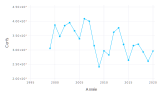

In [50]:
set_default_plot_size(16cm, 10cm)
df = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
plot(df, x=:Année, y=:Cerfs, Geom.line, Geom.point)

In [51]:
first(df, 5)

5×2 DataFrame
│ Row │ Année │ Cerfs │
│     │ Int64 │ Int64 │
├─────┼───────┼───────┤
│ 1   │ 1999  │ 30587 │
│ 2   │ 2000  │ 38737 │
│ 3   │ 2001  │ 34751 │
│ 4   │ 2002  │ 38501 │
│ 5   │ 2003  │ 39544 │

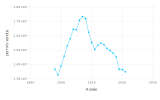

In [52]:
set_default_plot_size(16cm, 10cm)
plot(permis, x=:Année, y=:Total, Geom.line, Geom.point,
    Guide.ylabel("permis vendus"))

In [53]:
df2 = innerjoin(df, permis, on = :Année)

plot(df2, x=:Total, y=:Cerfs, Geom.point,
    Guide.xlabel("permis vendus"),
    Guide.ylabel("cerfs récoltés"))

In [54]:
first(df2, 5)

5×6 DataFrame
│ Row │ Année │ Cerfs │ Résidents │ Résidents premier abbatage │ Non-résidents │ Total  │
│     │ Int64 │ Int64 │ Int64     │ Union{Missing, Int64}      │ Int64         │ Int64  │
├─────┼───────┼───────┼───────────┼────────────────────────────┼───────────────┼────────┤
│ 1   │ 1999  │ 30587 │ 131325    │ 9082                       │ 1260          │ 132585 │
│ 2   │ 2000  │ 38737 │ 137346    │ 9082                       │ 1463          │ 138809 │
│ 3   │ 2001  │ 34751 │ 144074    │ 9082                       │ 1551          │ 145625 │
│ 4   │ 2002  │ 38501 │ 151154    │ 9082                       │ 1735          │ 152889 │
│ 5   │ 2003  │ 39544 │ 156229    │ 9082                       │ 1638          │ 157867 │

#### 2.2 Quantité de cerfs récoltés annuellement dans les différentes zones de chasse

On doit d'abord additionner le nombre de cerfs récoltés selon les différents engins de chasse.

In [55]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[])  # On initialise un DataFrame vide

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end

sort!(new_df, :Année)
first(new_df, 5)  

5×3 DataFrame
│ Row │ Année │ Zone  │ Cerfs │
│     │ Int64 │ Int64 │ Int64 │
├─────┼───────┼───────┼───────┤
│ 1   │ 1999  │ 2     │ 922   │
│ 2   │ 1999  │ 3     │ 1519  │
│ 3   │ 1999  │ 4     │ 4890  │
│ 4   │ 1999  │ 5     │ 2014  │
│ 5   │ 1999  │ 6     │ 4846  │

In [56]:
groupby(new_df, :Zone)[1].Zone[1]

2

In [57]:
new_df = innerjoin(new_df, permis[!, [:Année, :Total]], on = :Année)

366×4 DataFrame
│ Row │ Année │ Zone  │ Cerfs │ Total  │
│     │ Int64 │ Int64 │ Int64 │ Int64  │
├─────┼───────┼───────┼───────┼────────┤
│ 1   │ 1999  │ 2     │ 922   │ 132585 │
│ 2   │ 1999  │ 3     │ 1519  │ 132585 │
│ 3   │ 1999  │ 4     │ 4890  │ 132585 │
│ 4   │ 1999  │ 5     │ 2014  │ 132585 │
│ 5   │ 1999  │ 6     │ 4846  │ 132585 │
│ 6   │ 1999  │ 7     │ 1062  │ 132585 │
│ 7   │ 1999  │ 8     │ 2033  │ 132585 │
│ 8   │ 1999  │ 9     │ 1123  │ 132585 │
│ 9   │ 1999  │ 10    │ 5224  │ 132585 │
│ 10  │ 1999  │ 11    │ 965   │ 132585 │
⋮
│ 356 │ 2020  │ 9     │ 1089  │ 136413 │
│ 357 │ 2020  │ 10    │ 2993  │ 136413 │
│ 358 │ 2020  │ 11    │ 721   │ 136413 │
│ 359 │ 2020  │ 20    │ 2302  │ 136413 │
│ 360 │ 2020  │ 15    │ 541   │ 136413 │
│ 361 │ 2020  │ 1     │ 318   │ 136413 │
│ 362 │ 2020  │ 13    │ 6     │ 136413 │
│ 363 │ 2020  │ 12    │ 9     │ 136413 │
│ 364 │ 2020  │ 26    │ 330   │ 136413 │
│ 365 │ 2020  │ 27    │ 880   │ 136413 │
│ 366 │ 2020  │ 28    │ 151   │ 136413 │

In [58]:
zones = unique(new_df[!, :Zone])
pp = Plot[]
set_default_plot_size(16cm, 10cm)
for i = 1:length(zones)
    p = plot(groupby(new_df, :Zone)[i], x=:Total, y=:Cerfs, Geom.point, Geom.line, Guide.title("Zone $(groupby(new_df, :Zone)[i].Zone[1])"))
    push!(pp, p)
end

In [59]:
# Pour afficher seulement les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

In [60]:
select!(new_df, Not(:Cerfs), :Cerfs)

366×4 DataFrame
│ Row │ Année │ Zone  │ Total  │ Cerfs │
│     │ Int64 │ Int64 │ Int64  │ Int64 │
├─────┼───────┼───────┼────────┼───────┤
│ 1   │ 1999  │ 2     │ 132585 │ 922   │
│ 2   │ 1999  │ 3     │ 132585 │ 1519  │
│ 3   │ 1999  │ 4     │ 132585 │ 4890  │
│ 4   │ 1999  │ 5     │ 132585 │ 2014  │
│ 5   │ 1999  │ 6     │ 132585 │ 4846  │
│ 6   │ 1999  │ 7     │ 132585 │ 1062  │
│ 7   │ 1999  │ 8     │ 132585 │ 2033  │
│ 8   │ 1999  │ 9     │ 132585 │ 1123  │
│ 9   │ 1999  │ 10    │ 132585 │ 5224  │
│ 10  │ 1999  │ 11    │ 132585 │ 965   │
⋮
│ 356 │ 2020  │ 9     │ 136413 │ 1089  │
│ 357 │ 2020  │ 10    │ 136413 │ 2993  │
│ 358 │ 2020  │ 11    │ 136413 │ 721   │
│ 359 │ 2020  │ 20    │ 136413 │ 2302  │
│ 360 │ 2020  │ 15    │ 136413 │ 541   │
│ 361 │ 2020  │ 1     │ 136413 │ 318   │
│ 362 │ 2020  │ 13    │ 136413 │ 6     │
│ 363 │ 2020  │ 12    │ 136413 │ 9     │
│ 364 │ 2020  │ 26    │ 136413 │ 330   │
│ 365 │ 2020  │ 27    │ 136413 │ 880   │
│ 366 │ 2020  │ 28    │ 136413 │ 151   │

In [61]:
Random.seed!(3302)

ntrain = round(Int, .8*nrow(new_df))

train_id = sample(1:nrow(new_df), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(new_df), train_id)

train = new_df[train_id, :]
valid = new_df[valid_id, :]

73×4 DataFrame
│ Row │ Année │ Zone  │ Total  │ Cerfs │
│     │ Int64 │ Int64 │ Int64  │ Int64 │
├─────┼───────┼───────┼────────┼───────┤
│ 1   │ 1999  │ 2     │ 132585 │ 922   │
│ 2   │ 1999  │ 7     │ 132585 │ 1062  │
│ 3   │ 2000  │ 2     │ 138809 │ 1239  │
│ 4   │ 2001  │ 2     │ 145625 │ 801   │
│ 5   │ 2001  │ 3     │ 145625 │ 1374  │
│ 6   │ 2001  │ 4     │ 145625 │ 4199  │
│ 7   │ 2001  │ 7     │ 145625 │ 1260  │
│ 8   │ 2001  │ 11    │ 145625 │ 1397  │
│ 9   │ 2002  │ 3     │ 152889 │ 1724  │
│ 10  │ 2002  │ 9     │ 152889 │ 1868  │
⋮
│ 63  │ 2018  │ 2     │ 145118 │ 575   │
│ 64  │ 2018  │ 6     │ 145118 │ 4006  │
│ 65  │ 2018  │ 1     │ 145118 │ 634   │
│ 66  │ 2018  │ 13    │ 145118 │ 7     │
│ 67  │ 2018  │ 26    │ 145118 │ 105   │
│ 68  │ 2019  │ 2     │ 136583 │ 380   │
│ 69  │ 2019  │ 7     │ 136583 │ 2692  │
│ 70  │ 2019  │ 10    │ 136583 │ 3004  │
│ 71  │ 2020  │ 6     │ 136413 │ 4307  │
│ 72  │ 2020  │ 9     │ 136413 │ 1089  │
│ 73  │ 2020  │ 28    │ 136413 │ 151   │

In [62]:
# Standardisation des variables
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(train), dims=1)
transdata = StatsBase.transform(dt, Matrix{Float64}(train))

X = transdata[:,1:3]
y = transdata[:,4]

n = length(y)
m = size(X,2)

transdata = StatsBase.transform(dt, Matrix{Float64}(valid))

X_valid = transdata[:,1:3]
y_valid = transdata[:,4];

In [63]:
λ = 1.  # on défini lambda

β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.

3-element Vector{Float64}:
 -0.21414340101816484
 -0.21920902927500066
 -0.1125239445658846

In [64]:
df = DataFrame(λ = Float64[], rmse = Float64[])

for λ = 400:1:1000
    β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.
    
    ŷ = X_valid*β̂  # on fait une prédiction (comme avant) avec les données de test
    
    rmse = StatsBase.rmsd(ŷ, y_valid)  # on calcul le rmse (avec StatsBase...)
    
    push!(df, [λ, rmse])  # maintenant, il faut stocker ces résultats dans notre dataframe :
end

In [65]:
λ̂ = df.λ[argmin(df.rmse)]  # On vient trouver le lambda correspondant au plus petit rmse  (armgmin donne l'indice)

753.0

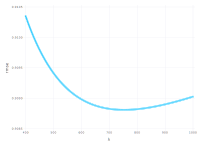

In [66]:
plot(df, x=:λ, y=:rmse, Geom.line, Geom.point,
    Guide.ylabel("rmse"))

---
## 3. Ajustement d'un modèle de régression linéaire simple

Pour cet exemple simple, on n'utilise que l'année comme variable explicative afin d'ajuster un modèle de régression linéaire pour chaque zone de chasse.

#### 3.1. Ajustement des modèles 

In [67]:
models = DataFrame(Zone = Int64[], β̂₀ = Float64[], β̂₁ = Float64[])  # On initialise le DataFrame vide

zones = groupby(new_df, :Zone)  # On groupe les données par zone
for zone in zones  # Pour chaque zone de chasse,

    y = zone.Cerfs
    n = length(y)
    
    x₁ = zone.Année  # On considère l'année seulement
    
    X = hcat(ones(n), x₁)

    β̂₀, β̂₁ =  X'X\X'y  # Estimation des coefficients de régression
    
    push!(models, [zone.Zone[1], β̂₀, β̂₁])  # On ajoute ça au DataFame
end

models

19×3 DataFrame
│ Row │ Zone  │ β̂₀         │ β̂₁        │
│     │ Int64 │ Float64    │ Float64   │
├─────┼───────┼────────────┼───────────┤
│ 1   │ 2     │ 49648.1    │ -24.2823  │
│ 2   │ 3     │ 9345.92    │ -3.75325  │
│ 3   │ 4     │ 1.27533e5  │ -61.5878  │
│ 4   │ 5     │ 5860.35    │ -2.00452  │
│ 5   │ 6     │ 97345.5    │ -46.1542  │
│ 6   │ 7     │ -1.33481e5 │ 67.8012   │
│ 7   │ 8     │ -63143.1   │ 32.8329   │
│ 8   │ 9     │ 78552.2    │ -38.4269  │
│ 9   │ 10    │ 3.70844e5  │ -181.819  │
│ 10  │ 11    │ 89790.6    │ -44.0288  │
│ 11  │ 20    │ 3.47452e5  │ -170.54   │
│ 12  │ 15    │ 20361.5    │ -10.0247  │
│ 13  │ 1     │ 28245.2    │ -13.4955  │
│ 14  │ 13    │ -329.849   │ 0.167669  │
│ 15  │ 12    │ 890.593    │ -0.435088 │
│ 16  │ 26    │ -17141.7   │ 8.55937   │
│ 17  │ 27    │ -52201.6   │ 26.2426   │
│ 18  │ 21    │ 614.309    │ -0.304455 │
│ 19  │ 28    │ -48756.1   │ 24.2      │

#### 3.2. Validation graphique

Pour avoir un aperçu de la qualité de la regression, on ajoute la droite de régression.

In [68]:
zones = unique(new_df[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(groupby(new_df, :Zone)[i], x=:Année, y=:Cerfs, Geom.point, Geom.line, Guide.title("Zone $(groupby(new_df, :Zone)[i].Zone[1])"),
            intercept=[models[i, :β̂₀]], slope=[models[i, :β̂₁]], Geom.abline(style=:dash, color="red"))
    push!(pp, p)
end

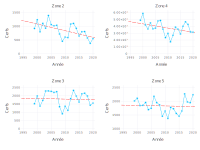

In [69]:
# Pour afficher les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

---
## 4. Estimation du nombre de cerfs mâles adultes récoltés par zone de chasse en 2021 

On utilise le modèle simple de la section précédente pour estimer le nombre de cerfs récoltés pour chacune des lignes de l'ensemble de test.

#### 4.1 Chargement des données de l'ensemble de test

In [70]:
test = CSV.read("data/test.csv", DataFrame);

#### 4.2 Estimation du nombre de cerfs récoltés pour chacune des ligne de l'ensemble de test.

In [71]:
models = models[in.(models.Zone, Ref(test.Zone)), :];  # On récupère seulement les modèles pour les zones à prévoir

In [72]:
ŷ = [Int64(ceil(models[i,:].β̂₁ * 2021 + models[i,:].β̂₀)) for i in 1:size(test,1)];

In [259]:
predvalid[!, :Cerfs] = round.(Int64, predvalid[!, :Prediction])

18-element Vector{Int64}:
 1927
  797
 2409
 5809
 2409
 5903
 2342
 3275
 1032
 5781
  866
   11
    6
  105
 5713
   95
  937
  -34

In [261]:
predvalid[!, :Zone] = round.(Int64, predvalid[!, :Zone])


18-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 15
 20
 26
 27
 28

In [262]:
df_submission = predvalid[:, [:Zone, :Cerfs]]

18×2 DataFrame
│ Row │ Zone  │ Cerfs │
│     │ Int64 │ Int64 │
├─────┼───────┼───────┤
│ 1   │ 1     │ 1927  │
│ 2   │ 2     │ 797   │
│ 3   │ 3     │ 2409  │
│ 4   │ 4     │ 5809  │
│ 5   │ 5     │ 2409  │
│ 6   │ 6     │ 5903  │
│ 7   │ 7     │ 2342  │
│ 8   │ 8     │ 3275  │
│ 9   │ 9     │ 1032  │
│ 10  │ 10    │ 5781  │
│ 11  │ 11    │ 866   │
│ 12  │ 12    │ 11    │
│ 13  │ 13    │ 6     │
│ 14  │ 15    │ 105   │
│ 15  │ 20    │ 5713  │
│ 16  │ 26    │ 95    │
│ 17  │ 27    │ 937   │
│ 18  │ 28    │ -34   │

In [247]:
CSV.write("portugal.csv", submission)

"portugal.csv"

In [265]:
StatsBase.rmsd(answers[!, "Cerfs"], predvalid[!, "Cerfs"])

1012.9010591146381

In [358]:
CSV.write("submission.csv", df_submission)

"submission.csv"

#### 4.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne de zones (Zone) et d'une colonne du nombre de cerfs récoltés (Cerfs).

In [73]:
prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("benchmark_predictions.csv", prediction)

"benchmark_predictions.csv"